# NYC Taxi Fare Prediction Project 
By.Mohamed Elshamy
## Project Overview
This project develops a machine learning model to predict taxi fares in New York City using various features including:
- Trip characteristics (distance, passengers)
- Location data (distances to landmarks)
- Temporal features (hour, weekday)
- Environmental conditions (weather, traffic)

## 1. Data Pipeline Setup
Importing necessary libraries for:
- Data manipulation (pandas, numpy)
- Visualization (matplotlib, seaborn)
- Machine learning (sklearn, xgboost)
- Model deployment (streamlit)

In [17]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
import pickle
import joblib
import streamlit as st


## 2. Data Loading and Initial Exploration
Loading the dataset and performing initial examination of its structure and contents.

In [18]:
df = pd.read_csv('final_internship_data.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 26 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   User ID            500000 non-null  object 
 1   User Name          500000 non-null  object 
 2   Driver Name        500000 non-null  object 
 3   Car Condition      500000 non-null  object 
 4   Weather            500000 non-null  object 
 5   Traffic Condition  500000 non-null  object 
 6   key                500000 non-null  object 
 7   fare_amount        500000 non-null  float64
 8   pickup_datetime    500000 non-null  object 
 9   pickup_longitude   500000 non-null  float64
 10  pickup_latitude    500000 non-null  float64
 11  dropoff_longitude  499995 non-null  float64
 12  dropoff_latitude   499995 non-null  float64
 13  passenger_count    500000 non-null  int64  
 14  hour               500000 non-null  int64  
 15  day                500000 non-null  int64  
 16  mo

## 3. Data Preprocessing Pipeline
### 3.1 Feature Engineering Steps:
1. Column renaming for clarity
2. Missing value analysis
3. Distance feature normalization using PCA
4. Log transformation of numerical features
5. Categorical variable encoding

In [19]:
# Rename columns for clarity
df.rename(columns={
    "jfk_dist": "jfk_airport_distance",
    "lga_dist": "lga_airport_distance",
    "ewr_dist": "ewr_airport_distance",
    "sol_dist": "statue_of_liberty_distance",
    "nyc_dist": "nyc_center_distance"
}, inplace=True)



df.columns[-25:]

Index(['User Name', 'Driver Name', 'Car Condition', 'Weather',
       'Traffic Condition', 'key', 'fare_amount', 'pickup_datetime',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'hour', 'day', 'month',
       'weekday', 'year', 'jfk_airport_distance', 'ewr_airport_distance',
       'lga_airport_distance', 'statue_of_liberty_distance',
       'nyc_center_distance', 'distance', 'bearing'],
      dtype='object')

In [20]:
# Check number and percentage of missing values in each column
missing_info = df.isnull().sum().to_frame(name='Missing Count')
missing_info['% Missing'] = 100 * missing_info['Missing Count'] / len(df)
missing_info = missing_info[missing_info['Missing Count'] > 0]  # show only columns with missing
missing_info.sort_values(by='Missing Count', ascending=False)


Missing Count  % Missing
dropoff_longitude                       5      0.001
dropoff_latitude                        5      0.001
jfk_airport_distance                    5      0.001
ewr_airport_distance                    5      0.001
lga_airport_distance                    5      0.001
statue_of_liberty_distance              5      0.001
nyc_center_distance                     5      0.001
distance                                5      0.001
bearing                                 5      0.001

In [21]:
df.dropna(subset=['dropoff_longitude', 'dropoff_latitude', 'jfk_airport_distance', 'ewr_airport_distance', 'lga_airport_distance', 'statue_of_liberty_distance', 'nyc_center_distance', 'distance', 'bearing'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 499995 entries, 0 to 499999
Data columns (total 26 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User ID                     499995 non-null  object 
 1   User Name                   499995 non-null  object 
 2   Driver Name                 499995 non-null  object 
 3   Car Condition               499995 non-null  object 
 4   Weather                     499995 non-null  object 
 5   Traffic Condition           499995 non-null  object 
 6   key                         499995 non-null  object 
 7   fare_amount                 499995 non-null  float64
 8   pickup_datetime             499995 non-null  object 
 9   pickup_longitude            499995 non-null  float64
 10  pickup_latitude             499995 non-null  float64
 11  dropoff_longitude           499995 non-null  float64
 12  dropoff_latitude            499995 non-null  float64
 13  passenger_count    

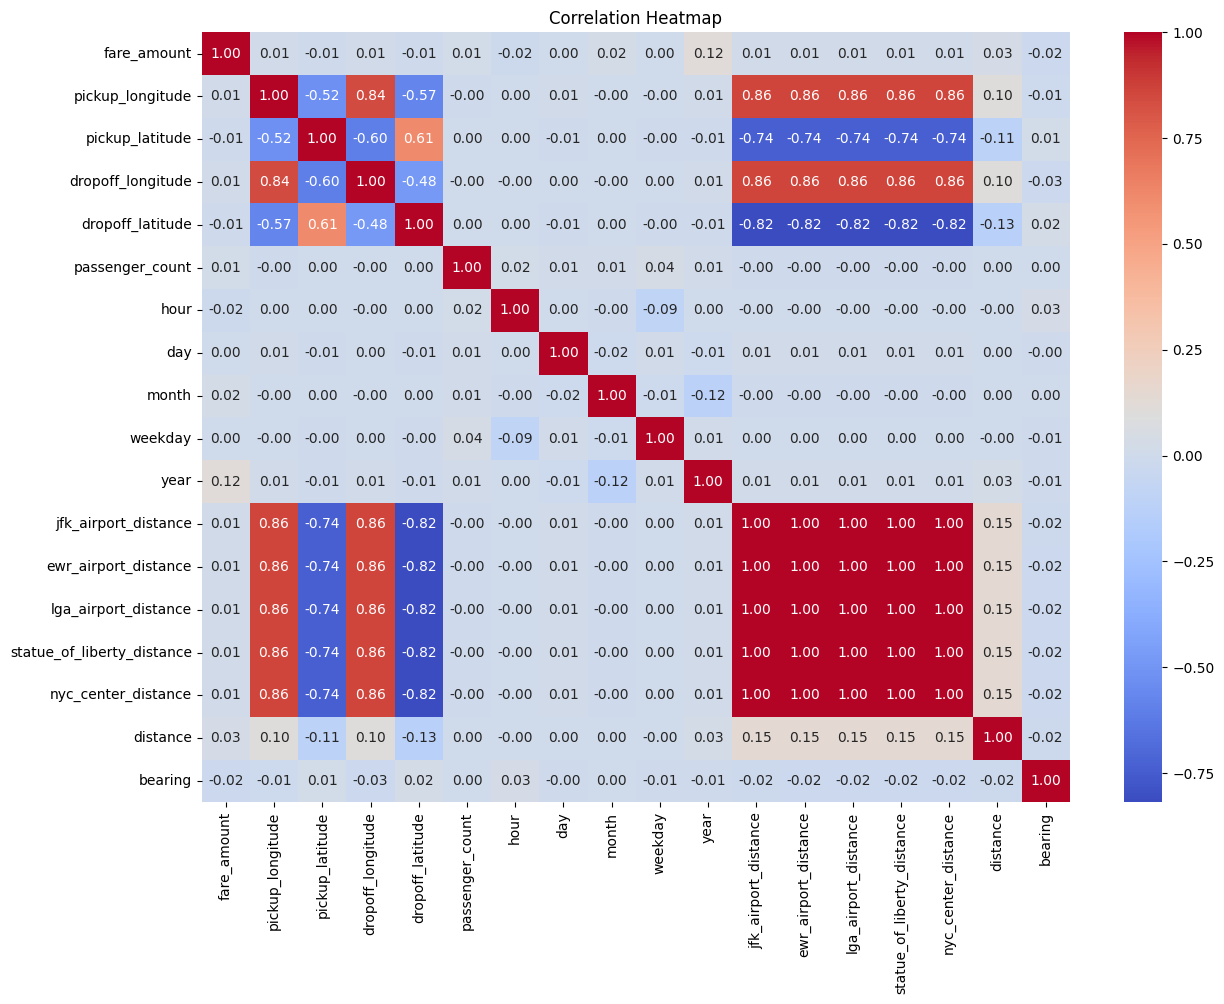

In [22]:
# Correlation Heatmap
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(14, 10))
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


## 4. Feature Engineering
### 4.1 Landmark Distance Processing
Using PCA to combine multiple distance features into a single representative feature

In [23]:
cols = ['jfk_airport_distance', 'ewr_airport_distance', 'lga_airport_distance',
        'nyc_center_distance', 'statue_of_liberty_distance']
# Normalize the data
X_landmarks = df[cols]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_landmarks)
df.dropna(inplace=True)

# Apply PCA (1 or 2 components usually enough)
pca = PCA(n_components=1)
df['landmark_distance_pca'] = pca.fit_transform(X_scaled)

# Drop original features
df.drop(columns=cols, inplace=True)
df.head()



User ID          User Name       Driver Name Car Condition Weather  \
0  KHVrEVlD     Kimberly Adams        Amy Butler     Very Good   windy   
1  lPxIuEri       Justin Tapia  Hannah Zimmerman     Excellent  cloudy   
2  gsVN8JLS    Elizabeth Lopez    Amanda Jackson           Bad  stormy   
3  9I7kWFgd      Steven Wilson          Amy Horn     Very Good  stormy   
4  8QN5ZaGN  Alexander Andrews  Cassandra Larson           Bad  stormy   

   Traffic Condition                            key  fare_amount  \
0  Congested Traffic    2009-06-15 17:26:21.0000001          4.5   
1       Flow Traffic    2010-01-05 16:52:16.0000002         16.9   
2  Congested Traffic   2011-08-18 00:35:00.00000049          5.7   
3       Flow Traffic    2012-04-21 04:30:42.0000001          7.7   
4  Congested Traffic  2010-03-09 07:51:00.000000135          5.3   

       pickup_datetime  pickup_longitude  ...  dropoff_latitude  \
0  2009-06-15 17:26:21         -1.288826  ...          0.710563   
1  2010-01-05 16:52:16         -1.291824  ...          0.711780   
2  2011-08-18 00:35:00         -1.291242  ...          0.711231   
3  2012-04-21 04:30:42         -1.291319  ...          0.711363   
4  2010-03-09 07:51:00         -1.290987  ...          0.711811   

   passenger_count  hour  day  month  weekday  year  distance   bearing  \
0                1    17   15      6        0  2009  1.030764 -2.918897   
1                1    16    5      1        1  2010  8.450134 -0.375217   
2                2     0   18      8        3  2011  1.389525  2.599961   
3                1     4   21      4        5  2012  2.799270  0.133905   
4                1     7    9      3        1  2010  1.999157 -0.502703   

   landmark_distance_pca  
0              -0.312922  
1              -0.318129  
2              -0.317904  
3              -0.318832  
4              -0.315595  

[5 rows x 22 columns]

## 5. Data Cleaning and Transformation
### 5.1 Handling Invalid Values
- Removing zero/negative values
- Setting reasonable value ranges
- Log transformation for fare and distance

In [24]:

print("Zero or Negative Value Counts:\n")

for col in ['fare_amount', 'passenger_count', 'distance']:
    count = df[df[col] <= 0].shape[0]
    print(f"{col}: {count} rows")



Zero or Negative Value Counts:

fare_amount: 35 rows
passenger_count: 1791 rows
distance: 14250 rows


In [25]:
# Remove rows with zero or negative values in key columns
df = df[(df['fare_amount'] > 0) & (df['passenger_count'] > 0) & (df['distance'] > 0)]

df = df[(df['fare_amount'] > 0) & (df['fare_amount'] < 100)]  # $100 max reasonable
df = df[(df['distance'] > 0) & (df['distance'] < 10)]        # 10 km max reasonable
df = df[(df['passenger_count'] > 0) & (df['passenger_count'] < 4)]        # 4 person Max reasonable

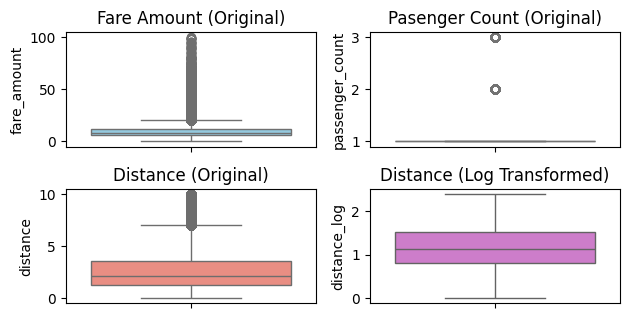

In [26]:
df['distance_log'] = np.log1p(df['distance'])

# Before
# Fare Amount
plt.subplot(3, 2, 1)
sns.boxplot(y=df['fare_amount'], color="skyblue")
plt.title("Fare Amount (Original)")

plt.subplot(3, 2, 2)
sns.boxplot(y=df['passenger_count'], color="lightgreen")
plt.title("Pasenger Count (Original)")

# Distance
plt.subplot(3, 2, 3)
sns.boxplot(y=df['distance'], color="salmon")
plt.title("Distance (Original)")

plt.subplot(3, 2, 4)
sns.boxplot(y=df['distance_log'], color="orchid")
plt.title("Distance (Log Transformed)")

plt.tight_layout()
plt.show()

In [27]:
cat_cols = ['Weather', 'Traffic Condition']

# Convert categorical columns to category dtype 
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=False)
car_condition_map = {
    "Bad": 0,
    "Good": 1,
    "Very Good": 2,
    "Excellent": 3
}
df_encoded['Car Condition'] = df_encoded['Car Condition'].map(car_condition_map)
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406193 entries, 0 to 499999
Data columns (total 29 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   User ID                              406193 non-null  object 
 1   User Name                            406193 non-null  object 
 2   Driver Name                          406193 non-null  object 
 3   Car Condition                        406193 non-null  int64  
 4   key                                  406193 non-null  object 
 5   fare_amount                          406193 non-null  float64
 6   pickup_datetime                      406193 non-null  object 
 7   pickup_longitude                     406193 non-null  float64
 8   pickup_latitude                      406193 non-null  float64
 9   dropoff_longitude                    406193 non-null  float64
 10  dropoff_latitude                     406193 non-null  float64
 11  passenger_count   

In [28]:
df_encoded.drop(columns=[
    "User ID", "key", "User Name", "Driver Name", "pickup_datetime", "day", "month", "year", "dropoff_latitude",
    "dropoff_longitude", "pickup_latitude", "pickup_longitude" , "distance"
], inplace=True)


df_encoded.columns[-30:]

Index(['Car Condition', 'fare_amount', 'passenger_count', 'hour', 'weekday',
       'bearing', 'landmark_distance_pca', 'distance_log', 'Weather_cloudy',
       'Weather_rainy', 'Weather_stormy', 'Weather_sunny', 'Weather_windy',
       'Traffic Condition_Congested Traffic',
       'Traffic Condition_Dense Traffic', 'Traffic Condition_Flow Traffic'],
      dtype='object')

## Data Split

In [29]:
# Prepare the data for modeling
y = df_encoded['fare_amount']
X = df_encoded.drop(columns=['fare_amount'])


# Step 1: Split into train+val and test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Step 2: Split train+val into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42
)  # 0.25 x 0.8 = 0.2 (i.e., 60% train, 20% val, 20% test)

# 3. Check the shapes
print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)

Train shape: (243715, 15)
Validation shape: (81239, 15)
Test shape: (81239, 15)


In [30]:
feature_order = ['Car Condition', 'passenger_count', 'hour', 'weekday',
       'bearing', 'landmark_distance_pca', 'distance_log', 'Weather_cloudy',
       'Weather_rainy', 'Weather_stormy', 'Weather_sunny', 'Weather_windy',
       'Traffic Condition_Congested Traffic',
       'Traffic Condition_Dense Traffic', 'Traffic Condition_Flow Traffic'
]
joblib.dump(feature_order, 'feature_order.pkl')

['feature_order.pkl']

## 6. General Models Test
### 6.1 Model Selection Process:
1. Linear Regression (baseline)
2. Random Forest
3. Gradient Boosting
4. XGBoost 

In [31]:

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "XGBoost": XGBRegressor()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_r2 = r2_score(y_train, y_train_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)

    test_r2 = r2_score(y_test, y_test_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    print(f"Model: {name}")
    print(f"Train - R2: {train_r2:.4f} | RMSE: {train_rmse:.4f} | MSE: {train_mse:.4f} | MAE: {train_mae:.4f}")
    print(f"Test  - R2: {test_r2:.4f} | RMSE: {test_rmse:.4f} | MSE: {test_mse:.4f} | MAE: {test_mae:.4f}")
    print("-" * 50)

Model: Linear Regression
Train - R2: 0.5112 | RMSE: 4.2474 | MSE: 18.0405 | MAE: 2.3525
Test  - R2: 0.5093 | RMSE: 4.2557 | MSE: 18.1108 | MAE: 2.3392
--------------------------------------------------
Model: Random Forest
Train - R2: 0.9556 | RMSE: 1.2799 | MSE: 1.6381 | MAE: 0.6865
Test  - R2: 0.6730 | RMSE: 3.4740 | MSE: 12.0685 | MAE: 1.8432
--------------------------------------------------
Model: Gradient Boosting
Train - R2: 0.6947 | RMSE: 3.3567 | MSE: 11.2677 | MAE: 1.8136
Test  - R2: 0.6751 | RMSE: 3.4629 | MSE: 11.9919 | MAE: 1.8248
--------------------------------------------------
Model: XGBoost
Train - R2: 0.7661 | RMSE: 2.9379 | MSE: 8.6312 | MAE: 1.6589
Test  - R2: 0.6755 | RMSE: 3.4604 | MSE: 11.9744 | MAE: 1.7705
--------------------------------------------------


## 7. Models Tuning

### 7.1 XGBoost Model
Hyperparameter optimization for XGBoost using RandomizedSearchCV

In [32]:

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_model = XGBRegressor()
search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=10,
    scoring='r2',
    cv=3,
    verbose=1,
    n_jobs=-1
)

search.fit(X_train, y_train)
print("Best parameters:", search.best_params_)
print("Best CV score (R2):", search.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Best CV score (R2): 0.6924685151450077


In [33]:
# Test
best_model = search.best_estimator_
best_model.fit(X_train, y_train)
y_train_pred = search.best_estimator_.predict(X_train)
y_test_pred = best_model.predict(X_test)
y_validation_pred = best_model.predict(X_val)


print("XGBoost Model traing result:")
train_r2 = r2_score(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, y_train_pred)

test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_test_pred)

val_r2 = r2_score(y_val, y_validation_pred)
val_mse = mean_squared_error(y_val, y_validation_pred)
val_rmse = np.sqrt(val_mse)
val_mae = mean_absolute_error(y_val, y_validation_pred)

print(f"Model: XGBoost")
print(f"    Train - R2: {train_r2:.4f} | RMSE: {train_rmse:.4f} | MSE: {train_mse:.4f} | MAE: {train_mae:.4f}")
print(f"    Test  - R2: {test_r2:.4f} | RMSE: {test_rmse:.4f} | MSE: {test_mse:.4f} | MAE: {test_mae:.4f}")
print(f"Validation - R2: {val_r2:.4f} | RMSE: {val_rmse:.4f} | MSE: {val_mse:.4f} | MAE: {val_mae:.4f}")
print("-" * 50)

XGBoost Model traing result:
Model: XGBoost
    Train - R2: 0.7101 | RMSE: 3.2708 | MSE: 10.6979 | MAE: 1.7492
    Test  - R2: 0.6833 | RMSE: 3.4186 | MSE: 11.6869 | MAE: 1.7701
Validation - R2: 0.6854 | RMSE: 3.3834 | MSE: 11.4474 | MAE: 1.7640
--------------------------------------------------


### 7.2 Random Forest

In [34]:
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2', None]  
}

rf_model = RandomForestRegressor(random_state=42)

rf_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=rf_param_grid,
    n_iter=10,
    scoring='r2',
    cv=3,
    verbose=1,
    n_jobs=-1
)

rf_search.fit(X_train, y_train)

print("Random Forest Best Parameters:", rf_search.best_params_)
print("Random Forest Best CV Score (R2):", rf_search.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Random Forest Best Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 10}
Random Forest Best CV Score (R2): 0.6851718497725018


In [35]:
best_rf = rf_search.best_estimator_
best_rf.fit(X_train, y_train)

y_train_pred = rf_search.best_estimator_.predict(X_train)
y_test_pred = best_rf.predict(X_test)
y_validation_pred = best_rf.predict(X_val)

print("Random forest Model traing result:")
train_r2 = r2_score(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, y_train_pred)

test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_test_pred)

val_r2 = r2_score(y_val, y_validation_pred)
val_mse = mean_squared_error(y_val, y_validation_pred)
val_rmse = np.sqrt(val_mse)
val_mae = mean_absolute_error(y_val, y_validation_pred)

print(f"Model: Random Forest")
print(f"    Train - R2: {train_r2:.4f} | RMSE: {train_rmse:.4f} | MSE: {train_mse:.4f} | MAE: {train_mae:.4f}")
print(f"    Test  - R2: {test_r2:.4f} | RMSE: {test_rmse:.4f} | MSE: {test_mse:.4f} | MAE: {test_mae:.4f}")
print(f"Validation - R2: {val_r2:.4f} | RMSE: {val_rmse:.4f} | MSE: {val_mse:.4f} | MAE: {val_mae:.4f}")
print("-" * 50)

Random forest Model traing result:
Model: Random Forest
    Train - R2: 0.7352 | RMSE: 3.1260 | MSE: 9.7717 | MAE: 1.7587
    Test  - R2: 0.6755 | RMSE: 3.4608 | MSE: 11.9772 | MAE: 1.8354
Validation - R2: 0.6802 | RMSE: 3.4113 | MSE: 11.6367 | MAE: 1.8201
--------------------------------------------------


### 7.3 Gradient Boosting

In [36]:
gb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

gb_model = GradientBoostingRegressor(random_state=42)

gb_search = RandomizedSearchCV(
    estimator=gb_model,
    param_distributions=gb_param_grid,
    n_iter=10,
    scoring='r2',
    cv=3,
    verbose=1,
    n_jobs=-1
)

gb_search.fit(X_train, y_train)

print("Gradient Boosting Best Parameters:", gb_search.best_params_)
print("Gradient Boosting Best CV Score (R2):", gb_search.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Gradient Boosting Best Parameters: {'subsample': 0.8, 'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 5, 'learning_rate': 0.1}
Gradient Boosting Best CV Score (R2): 0.6892372766460788


In [40]:
best_gb = gb_search.best_estimator_
best_gb.fit(X_train, y_train)

y_train_pred = gb_search.best_estimator_.predict(X_train)
y_test_pred = best_gb.predict(X_test)
y_validation_pred = best_gb.predict(X_val)

print("Gradient Boosting Model traing result:")
train_r2 = r2_score(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, y_train_pred)

test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_test_pred)

val_r2 = r2_score(y_val, y_validation_pred)
val_mse = mean_squared_error(y_val, y_validation_pred)
val_rmse = np.sqrt(val_mse)
val_mae = mean_absolute_error(y_val, y_validation_pred)

print(f"Model: Gradient Boosting")
print(f"    Train - R2: {train_r2:.4f} | RMSE: {train_rmse:.4f} | MSE: {train_mse:.4f} | MAE: {train_mae:.4f}")
print(f"    Test  - R2: {test_r2:.4f} | RMSE: {test_rmse:.4f} | MSE: {test_mse:.4f} | MAE: {test_mae:.4f}")
print(f"Validation - R2: {val_r2:.4f} | RMSE: {val_rmse:.4f} | MSE: {val_mse:.4f} | MAE: {val_mae:.4f}")
print("-" * 50)

Gradient Boosting Model traing result:
Model: Gradient Boosting
    Train - R2: 0.7255 | RMSE: 3.1826 | MSE: 10.1288 | MAE: 1.7475
    Test  - R2: 0.6806 | RMSE: 3.4332 | MSE: 11.7869 | MAE: 1.7837
Validation - R2: 0.6844 | RMSE: 3.3888 | MSE: 11.4841 | MAE: 1.7786
--------------------------------------------------


In [41]:
# Get predictions from all models
models = {
    'XGBoost': best_model,
    'Random Forest': best_rf,
    'Gradient Boosting': best_gb
}

# Initialize dictionaries to store metrics
train_metrics = {'R2': [], 'RMSE': [], 'MSE': [], 'MAE': []}
test_metrics = {'R2': [], 'RMSE': [], 'MSE': [], 'MAE': []}
val_metrics = {'R2': [], 'RMSE': [], 'MSE': [], 'MAE': []}

# Calculate metrics for each model
for name, model in models.items():
    # Get predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_val_pred = model.predict(X_val)
    
    # Training metrics
    train_metrics['R2'].append(r2_score(y_train, y_train_pred))
    train_metrics['MSE'].append(mean_squared_error(y_train, y_train_pred))
    train_metrics['RMSE'].append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
    train_metrics['MAE'].append(mean_absolute_error(y_train, y_train_pred))
    
    # Test metrics
    test_metrics['R2'].append(r2_score(y_test, y_test_pred))
    test_metrics['MSE'].append(mean_squared_error(y_test, y_test_pred))
    test_metrics['RMSE'].append(np.sqrt(mean_squared_error(y_test, y_test_pred)))
    test_metrics['MAE'].append(mean_absolute_error(y_test, y_test_pred))
    
    # Validation metrics
    val_metrics['R2'].append(r2_score(y_val, y_val_pred))
    val_metrics['MSE'].append(mean_squared_error(y_val, y_val_pred))
    val_metrics['RMSE'].append(np.sqrt(mean_squared_error(y_val, y_val_pred)))
    val_metrics['MAE'].append(mean_absolute_error(y_val, y_val_pred))

# Calculate averages
avg_train_r2 = np.mean(train_metrics['R2'])
avg_train_rmse = np.mean(train_metrics['RMSE'])
avg_train_mse = np.mean(train_metrics['MSE'])
avg_train_mae = np.mean(train_metrics['MAE'])

avg_test_r2 = np.mean(test_metrics['R2'])
avg_test_rmse = np.mean(test_metrics['RMSE'])
avg_test_mse = np.mean(test_metrics['MSE'])
avg_test_mae = np.mean(test_metrics['MAE'])

avg_val_r2 = np.mean(val_metrics['R2'])
avg_val_rmse = np.mean(val_metrics['RMSE'])
avg_val_mse = np.mean(val_metrics['MSE'])
avg_val_mae = np.mean(val_metrics['MAE'])

print("Average Performance Across All Models:")
print("-" * 50)
print(f"    Train - R2: {avg_train_r2:.4f} | RMSE: {avg_train_rmse:.4f} | MSE: {avg_train_mse:.4f} | MAE: {avg_train_mae:.4f}")
print(f"    Test  - R2: {avg_test_r2:.4f} | RMSE: {avg_test_rmse:.4f} | MSE: {avg_test_mse:.4f} | MAE: {avg_test_mae:.4f}")
print(f"Validation - R2: {avg_val_r2:.4f} | RMSE: {avg_val_rmse:.4f} | MSE: {avg_val_mse:.4f} | MAE: {avg_val_mae:.4f}")

Average Performance Across All Models:
--------------------------------------------------
    Train - R2: 0.7236 | RMSE: 3.1931 | MSE: 10.1995 | MAE: 1.7518
    Test  - R2: 0.6798 | RMSE: 3.4375 | MSE: 11.8170 | MAE: 1.7964
Validation - R2: 0.6833 | RMSE: 3.3945 | MSE: 11.5227 | MAE: 1.7876


## 8. Model Deployment
### 8.1 Streamlit Web Application
Creating an interactive web interface for real-time predictions

In [ ]:
pickle.dump(best_model, open("gxb_model.pkl", "wb"))
pickle.dump(best_rf, open("rf_model.pkl", "wb"))
pickle.dump(best_gb, open("gb_model.pkl", "wb"))
pickle.dump(scaler, open("scaler.pkl", "wb"))
pickle.dump(pca, open("pca.pkl", "wb"))